## Preparation

In [1]:
data_location = 'sqlite:///data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [6]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [7]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Data formatting

In [8]:
tokens = ohlc.token.unique()

In [9]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df),
            ret=(df.high-df.low)/df.close,
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [10]:
X = X.dropna(axis=0)

In [11]:
X.tail()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.009342,0.158369,0.009661,0.002463,0.0002,0.216740,0.010513,0.225286,0.019297,...,0.239258,0.019207,0.254118,0.014595,0.255464,0.015198,0.207758,0.016290,0.284268,0.014145
2021-12-14 21:00:00,0.142237,0.021634,0.170096,0.024036,0.002652,0.0003,0.218492,0.025745,0.224116,0.018192,...,0.241603,0.023402,0.254350,0.019861,0.263456,0.029762,0.222014,0.029426,0.281497,0.020716
2021-12-14 22:00:00,0.151148,0.018920,0.172081,0.013881,0.002684,0.0002,0.246122,0.037369,0.232362,0.025266,...,0.268875,0.042341,0.253472,0.022800,0.270895,0.031977,0.220598,0.015419,0.275083,0.022349
2021-12-14 23:00:00,0.149424,0.009829,0.170257,0.010746,0.002823,0.0002,0.238235,0.017364,0.231115,0.013461,...,0.301778,0.050999,0.245708,0.014733,0.268758,0.020588,0.219474,0.010785,0.271229,0.011941
2021-12-15 00:00:00,0.143079,0.004857,0.159883,0.007910,0.002816,0.0001,0.228867,0.009413,0.220068,0.010075,...,0.296444,0.016520,0.234522,0.007390,0.242546,0.005900,0.213360,0.013251,0.246067,0.006923


In [12]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [13]:
X.shape

(1046, 22)

In [14]:
y.shape

(1046,)

Let's analyze our data a little bit

In [15]:
y.describe()

count    1046.000000
mean        0.018835
std         0.010662
min         0.000554
25%         0.011898
50%         0.016284
75%         0.023010
max         0.112903
Name: ret_SOL, dtype: float64

In [16]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

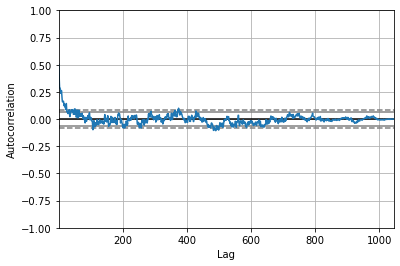

In [17]:
autocorrelation_plot(y[1:])

In [18]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.36899522053187767,
 'ret_BTC': 0.44902378230512524,
 'vol_ETH': 0.40647192396690396,
 'ret_ETH': 0.4379178970560085,
 'vol_USDT': 0.279661084072028,
 'ret_USDT': 0.22659733541534938,
 'vol_SOL': 0.4547482699553012,
 'ret_SOL': 0.5018798842346885,
 'vol_ADA': 0.3384820968171961,
 'ret_ADA': 0.3899273446735783,
 'vol_DOT': 0.35582519086622005,
 'ret_DOT': 0.435332128626756,
 'vol_AVAX': 0.3467587153074309,
 'ret_AVAX': 0.38778935422647465,
 'vol_ATOM': 0.4226160950450425,
 'ret_ATOM': 0.46680918787605336,
 'vol_CRV': 0.30196151318977865,
 'ret_CRV': 0.3442366506078685,
 'vol_AAVE': 0.36252905759702425,
 'ret_AAVE': 0.44011643270356265,
 'vol_COMP': 0.33620070925559525,
 'ret_COMP': 0.41014456257843723}

## Modelling

In [19]:
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [20]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [21]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

In [22]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008781405264173774

In [23]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.00898040091215299

In [24]:
pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.009313746655669357

In [25]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.007463565022815582

In [26]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.006261133957765003

In [27]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.006831962554230401

In [28]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.006210713124619741

In [29]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.00638898270561535

In [30]:
pipeline = Pipeline([
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.006570599629010174

In [31]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('model', Lasso(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.007026906392284674

In [32]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])

evaluate_model(pipeline, X, y)

-0.006065632702124328

In [33]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('model', lgb.LGBMRegressor(objective='regression'))
])

evaluate_model(pipeline, X, y)

-0.006629193696727434

The above looks pretty good, however let's optimize the alpha parameter on the Ridge

In [34]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=209, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [35]:
search.best_params_

{'model__alpha': 0.1, 'pca__n_components': 10}

In [36]:
best_model = search.best_estimator_

In [37]:
evaluate_model(best_model, X, y)

-0.005932873298137873

Let's check the learning curve of our best model

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

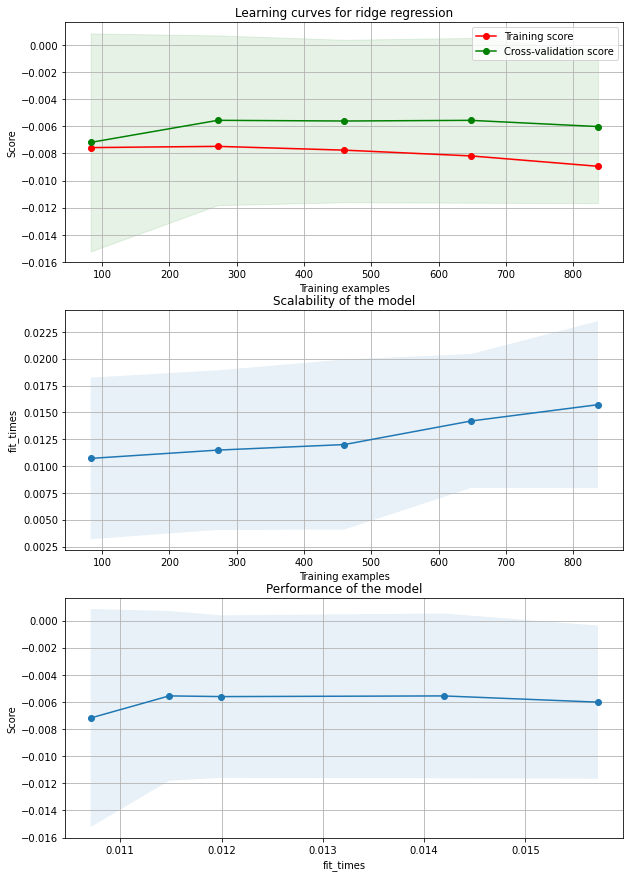

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


In [39]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))